In [1]:

import numpy as np
from cellpose import (
    core,
    models,
    denoise
)
from torch.utils.data import (
    ConcatDataset,
    DataLoader
)

import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

assert core.use_gpu() == 1, "No GPU detected"


In [2]:
model = denoise.CellposeDenoiseModel(gpu=1, model_type='cyto3', restore_type="denoise_cyto3")

## Dataset

In [4]:
import os
from typing import Tuple

import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class CellposeDataset(Dataset):
    images: list[np.ndarray]
    masks: list[np.ndarray]
    blend: float
    rng: np.random.Generator
    pdf: callable

    def __init__(self, path: str, blend: float = 1.):
        n_files = len(os.listdir(path))
        assert n_files % 2 == 0

        count = n_files // 2

        print("Loading images")
        self.images = list(map(
            lambda idx: np.array(Image.open("{}/{:03}_img.png".format(
                path, idx
            ))),
            range(count)
        ))

        print("Loading masks")
        self.masks = list(map(
            lambda idx: np.array(Image.open("{}/{:03}_masks.png".format(
                path, idx
            ))),
            range(count)
        ))
    
    def getRNG(self) -> np.random.Generator:
        return self.rng

    def __getitem__(self,idx: int) -> Tuple[np.array, np.array]:
        img = self.images[idx]
        return img/255., self.masks[idx]

    def __len__(self) -> int:
        return len(self.images)


In [5]:
dt = CellposeDataset("./test")

Loading images
Loading masks


# Images

In [5]:
img, real_mask = dt[0]
masks, flows, styles, imgs_dn = model.eval(img, diameter=None, flow_threshold=None, channels=[2,1])
masks = ~np.isin(masks, [0])
real_mask = ~np.isin(real_mask, [0])

In [6]:
masks, flows, styles, imgs_dn = model.eval(img, diameter=None, flow_threshold=None, channels=[2,1])

In [7]:
from cellpose import utils
len(utils.outlines_list(masks))

90

In [8]:
list(map(
    lambda x: (np.max(x, axis=0), np.min(x, axis=0)),
    utils.outlines_list(masks)
))


[(array([120,  37]), array([69,  0])),
 (array([212,  28]), array([168,   0])),
 (array([280,  10]), array([261,   0])),
 (array([344,  25]), array([319,   0])),
 (array([511,  22]), array([431,   0])),
 (array([72, 57]), array([14,  1])),
 (array([21, 39]), array([0, 3])),
 (array([444,  53]), array([385,   7])),
 (array([169,  47]), array([129,  29])),
 (array([509,  49]), array([478,  30])),
 (array([304,  89]), array([239,  38])),
 (array([34, 92]), array([ 0, 42])),
 (array([503,  74]), array([468,  48])),
 (array([398,  98]), array([359,  55])),
 (array([135, 131]), array([87, 56])),
 (array([86, 95]), array([46, 59])),
 (array([332, 118]), array([247,  59])),
 (array([233,  96]), array([195,  61])),
 (array([511,  93]), array([497,  67])),
 (array([22, 98]), array([ 0, 68])),
 (array([174, 120]), array([137,  84])),
 (array([431, 139]), array([362,  86])),
 (array([492, 143]), array([428,  87])),
 (array([ 90, 108]), array([43, 89])),
 (array([246,  97]), array([235,  92])),
 (a

(np.float64(-0.5), np.float64(511.5), np.float64(382.5), np.float64(-0.5))

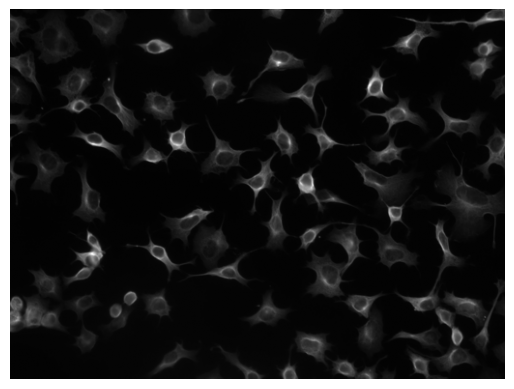

In [9]:
plt.imshow(img[:,:,1], cmap='gray')
plt.axis('off')

In [10]:
styles.shape

(256,)

(np.float64(-0.5), np.float64(511.5), np.float64(382.5), np.float64(-0.5))

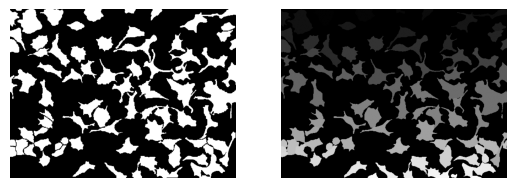

In [11]:
ax = plt.subplot(1, 2, 1)
ax.imshow(real_mask, cmap='gray')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(masks, cmap='gray')
ax.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(382.5), np.float64(-0.5))

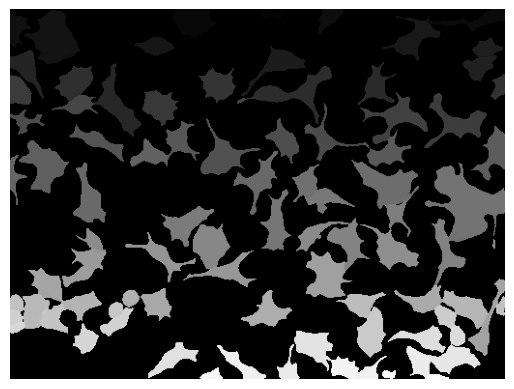

In [12]:
plt.imshow(masks ^ real_mask, cmap='gray')
plt.axis('off')

# Tests

In [18]:
noise_levels = np.arange(0., 1.01, 0.1)
noise_mean = 0
random_image_index = np.random.randint(0, len(dt))

In [19]:
def compute_acc_prec(masks: np.array, real_mask: np.array) -> tuple[float, float]:
    masks = np.isin(masks, [0])
    real_mask = np.isin(real_mask, [0])

    tot = masks.shape[0]*masks.shape[1]
    fp_plus_fn = np.count_nonzero(masks ^ real_mask)
    tp = np.count_nonzero(masks & real_mask)
    fp = np.count_nonzero(masks & ~real_mask)

    accuracy = 1 - fp_plus_fn / tot
    precision = tp / (tp + fp)

    return accuracy, precision

In [20]:
from multiprocessing.pool import ThreadPool

def compute_accuracy_and_precision(filter_ = None) -> tuple[float, float]:
	def running_ex(i):
		print(f"{i} / {len(dt)}")
		img, real_mask = dt[i]
		if filter_ is not None:
			img = filter_(img)
		masks, flows, styles, imgs_dn = model.eval(img, diameter=None, flow_threshold=None, channels=[2,1])
		
		return compute_acc_prec(masks, real_mask)

	pool = ThreadPool(4)
	acc_prec = pool.map(running_ex, range(len(dt)))

	sum_accuracy = sum(map(
		lambda x: x[0],
		acc_prec
	))
	sum_precision = sum(map(
		lambda x: x[1],
		acc_prec
	))
	return (sum_accuracy / len(dt)), (sum_precision / len(dt))


## First results for signal independant noises

In [ ]:
output_normal = []
rng = np.random.default_rng()
noise_level = np.arange(0., 0.3+0.01, 0.03)

for noise in noise_level:
	print(f"Testing dataset with noise of {noise}")
	def img_filter(img: np.array) -> np.array:
		out = img + noise * rng.normal(size=img.shape)
		return np.clip(out, 0., 1.)
	
	output_normal.append(compute_accuracy_and_precision(img_filter))
output_normal = np.array(output_normal)

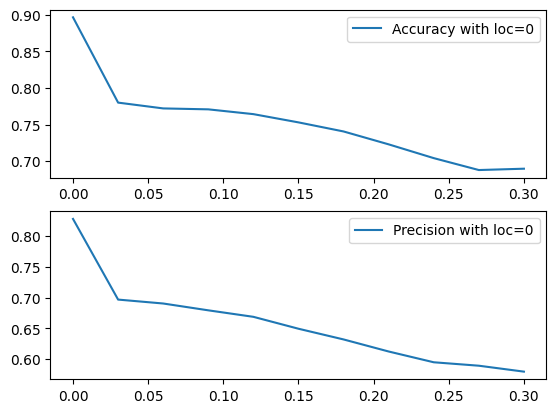

In [44]:
ax = plt.subplot(2, 1, 1)
ax.plot(noise_level, output_normal[:,0], label=f"Accuracy with loc={0}")
ax.legend()
ax = plt.subplot(2, 1, 2)
ax.plot(noise_level, output_normal[:,1], label=f"Precision with loc={0}")
ax.legend()
plt.show()

In [ ]:
output_poisson = []
lam = 4.

for noise in noise_level:
	print(f"Testing dataset with noise of {noise}")
	def img_filter(img: np.array) -> np.array:
		out = img + noise * rng.poisson(lam=lam, size=img.shape)
		return np.clip(out, 0., 1.)
	
	output_poisson.append(compute_accuracy_and_precision(img_filter))
output_poisson = np.array(output_poisson)

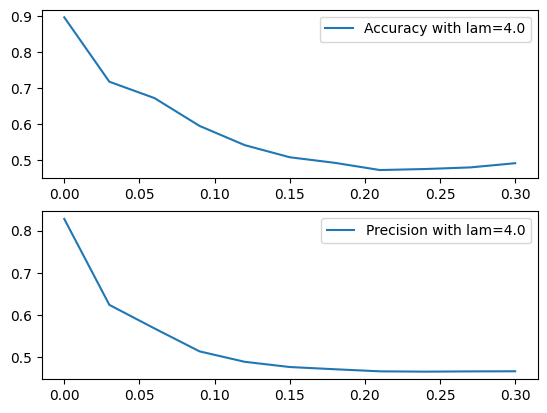

In [46]:
ax = plt.subplot(2, 1, 1)
ax.plot(noise_level, output_poisson[:,0], label=f"Accuracy with lam={lam}")
ax.legend()
ax = plt.subplot(2, 1, 2)
ax.plot(noise_level, output_poisson[:,1], label=f"Precision with lam={lam}")
ax.legend()
plt.show()

## Blurring


In [13]:
from scipy.ndimage import gaussian_filter

In [ ]:
gaussian_std = np.arange(0., 3.01, 1.0)
noise_level = np.arange(0., 0.3+0.01, 0.03)

output_normal_with_filter = []
rng = np.random.default_rng()

for noise in noise_level:
    tmp = []
    for blur_std in gaussian_std:
        print(f"Testing dataset with noise of {noise} & blur {blur_std}")
        def img_filter(img: np.array) -> np.array:
            out = gaussian_filter(img, sigma=blur_std) + noise * rng.normal(size=img.shape)
            return np.clip(out, 0., 1.)
        
        tmp.append(compute_accuracy_and_precision(img_filter))
    output_normal_with_filter.append(tmp)
output_normal_with_filter = np.array(output_normal_with_filter)

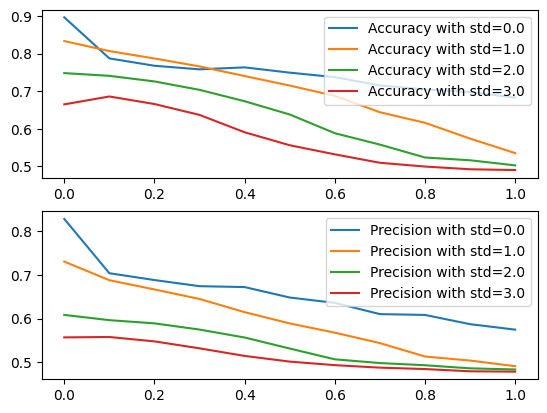

In [ ]:
for i, std in enumerate(gaussian_std):
    ax = plt.subplot(2, 1, 1)
    ax.plot(noise_level, output_normal_with_filter[:,i,0], label=f"Accuracy with std={std}")
    ax.legend()
    ax = plt.subplot(2, 1, 2)
    ax.plot(noise_level, output_normal_with_filter[:,i,1], label=f"Precision with std={std}")
    ax.legend()
plt.show()

## Adversarial noise

In [ ]:
def mod(a, b):
	out = a % b
	if out == 0:
		out = b
	return out

def transform(img, mask):
	img = img.transpose(2,0,1)
	pads = [(0, 0), (4 - mod(img.shape[1], 4), 0), (4 - mod(img.shape[2], 4), 0)]
	img = np.pad(img, pads, mode="constant")
	pads = pads[1:]
	mask = np.pad(mask, pads, mode="constant")
	return (img, mask)

In [15]:
def update_tile(img, x, y, tile_size, eps=2.5e-3):
    img_tensor = torch.from_numpy(img[[2, 0, 1],x:x+tile_size,y:y+tile_size]).to(model.dn.device, dtype=torch.float32).unsqueeze(1)
    img_tensor.requires_grad_(True)
    img_tensor.retain_grad()
    output_tensor = model.dn.net(img_tensor)[0]
    score = ((output_tensor - img_tensor)**2).sum()
    score.backward()
    with torch.no_grad():
        if img_tensor.grad is not None:
            grad = img_tensor.grad
            grad = grad.squeeze(1)
            img[:,x:x+tile_size,y:y+tile_size] += eps * np.sign(grad.cpu().numpy())
    return img

In [16]:
TILE_SIZES = [8, 16, 32, 64, 128]

In [21]:
acc_and_prec = []

for tile_size in TILE_SIZES:
	acc_and_prec_tile = []
	for i, (img, real_mask) in enumerate(dt):
		(img, real_mask) = transform(img, real_mask)
		img_width = img.shape[1]
		img_height = img.shape[2]
		img2 = img.copy()
		acc_and_prec_img = []
		if tile_size > img_width or tile_size > img_height:
			break
		print(f"[{i+1} / {len(dt)}] tile size {tile_size}")
		for j in range(300 // tile_size + 30):
			masks, _, _, _ = model.eval(img2, diameter=None, flow_threshold=None, channels=[2,1])
			accuracy, precision = compute_acc_prec(masks, real_mask)
			acc_and_prec_img.append([np.linalg.norm(img2 - img), accuracy, precision])
			img2 = update_tile(
				img2,
				np.random.randint(0, img_width - tile_size),
				np.random.randint(0, img_height - tile_size),
				tile_size
			)
		acc_and_prec_tile.append(acc_and_prec_img)
	acc_and_prec.append(acc_and_prec_tile)
acc_and_prec = list(map(np.array, acc_and_prec))

[1 / 68] tile size 8
[2 / 68] tile size 8
[3 / 68] tile size 8
[4 / 68] tile size 8
[5 / 68] tile size 8
[6 / 68] tile size 8
[7 / 68] tile size 8
[8 / 68] tile size 8
[9 / 68] tile size 8
[10 / 68] tile size 8
[11 / 68] tile size 8
[12 / 68] tile size 8
[13 / 68] tile size 8


/home/user/Devoirs/ProjetInte/cellpose/transforms.py:602: UserWarning: 'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0
  warnings.warn(


[14 / 68] tile size 8
[15 / 68] tile size 8
[16 / 68] tile size 8
[17 / 68] tile size 8
[18 / 68] tile size 8
[19 / 68] tile size 8
[20 / 68] tile size 8
[21 / 68] tile size 8
[22 / 68] tile size 8
[23 / 68] tile size 8
[24 / 68] tile size 8
[25 / 68] tile size 8
[26 / 68] tile size 8
[27 / 68] tile size 8
[28 / 68] tile size 8
[29 / 68] tile size 8
[30 / 68] tile size 8
[31 / 68] tile size 8
[32 / 68] tile size 8
[33 / 68] tile size 8
[34 / 68] tile size 8
[35 / 68] tile size 8
[36 / 68] tile size 8
[37 / 68] tile size 8
[38 / 68] tile size 8
[39 / 68] tile size 8
[40 / 68] tile size 8
[41 / 68] tile size 8
[42 / 68] tile size 8
[43 / 68] tile size 8
[44 / 68] tile size 8
[45 / 68] tile size 8
[46 / 68] tile size 8
[47 / 68] tile size 8
[48 / 68] tile size 8
[49 / 68] tile size 8
[50 / 68] tile size 8
[51 / 68] tile size 8
[52 / 68] tile size 8
[53 / 68] tile size 8
[54 / 68] tile size 8
[55 / 68] tile size 8
[56 / 68] tile size 8
[57 / 68] tile size 8
[58 / 68] tile size 8
[59 / 68] 

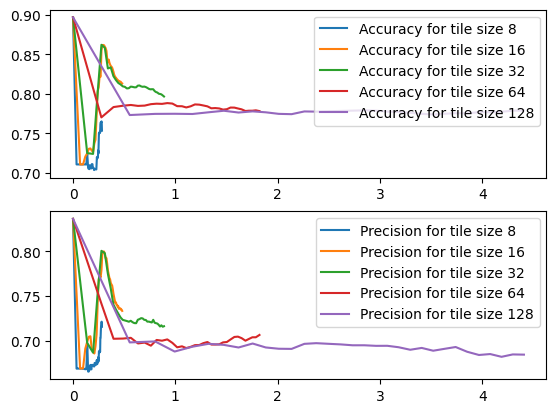

In [22]:
for i, tile_size in enumerate(TILE_SIZES):
    acc_and_prec_mean = acc_and_prec[i].mean(axis=0)
    it = acc_and_prec_mean[:,0]
    ax = plt.subplot(2, 1, 1)
    ax.plot(it, acc_and_prec_mean[:,1], label = "Accuracy for tile size {}".format(tile_size))
    ax.legend()

    ax = plt.subplot(2, 1, 2)
    ax.plot(it, acc_and_prec_mean[:,2], label = "Precision for tile size {}".format(tile_size))
    ax.legend()

## Other adversarial examples

## Genetic algorithm

https://arxiv.org/pdf/2104.15064

In [ ]:
help(cma)

Help on package cma:

NAME
    cma

DESCRIPTION
    Package `cma` implements the CMA-ES (Covariance Matrix Adaptation
    Evolution Strategy).

    CMA-ES is a stochastic optimizer for robust non-linear non-convex
    derivative- and function-value-free numerical optimization.

    This implementation can be used with Python versions >= 2.7, namely,
    it was tested with 2.7, 3.5, 3.6, 3.7, 3.8.

    CMA-ES searches for a minimizer (a solution x in :math:`R^n`) of an
    objective function f (cost function), such that f(x) is minimal.
    Regarding f, only a passably reliable ranking of the candidate
    solutions in each iteration is necessary. Neither the function values
    itself, nor the gradient of f need to be available or do matter (like
    in the downhill simplex Nelder-Mead algorithm). Some termination
    criteria however depend on actual f-values.

    The `cma` module provides two independent implementations of the
    CMA-ES algorithm in the classes `cma.CMAEvolutionStr

In [ ]:
help(cma.CMAEvolutionStrategy)

Help on class CMAEvolutionStrategy in module cma.evolution_strategy:

class CMAEvolutionStrategy(cma.interfaces.OOOptimizer)
 |  CMAEvolutionStrategy(x0, sigma0, inopts=None, options=None)
 |
 |  CMA-ES stochastic optimizer class with ask-and-tell interface.
 |
 |  Calling Sequences
 |  =================
 |
 |  - ``es = CMAEvolutionStrategy(x0, sigma0)``
 |
 |  - ``es = CMAEvolutionStrategy(x0, sigma0, opts)``
 |
 |  - ``es = CMAEvolutionStrategy(x0, sigma0).optimize(objective_fct)``
 |
 |  - ::
 |
 |      res = CMAEvolutionStrategy(x0, sigma0,
 |                              opts).optimize(objective_fct).result
 |
 |  Arguments
 |  =========
 |  `x0`
 |      initial solution, starting point. `x0` is given as "phenotype"
 |      which means, if::
 |
 |          opts = {'transformation': [transform, inverse]}
 |
 |      is given and ``inverse is None``, the initial mean is not
 |      consistent with `x0` in that ``transform(mean)`` does not
 |      equal to `x0` unless ``transform(mean

In [ ]:
x, y = 0, 0
width, height = 128, 128
imgb = dt[0][0][x:x+width,y:y+height,:]
mask = dt[0][1][x:x+width,y:y+height]

In [ ]:
img_vec = imgb.reshape(-1) / 255.
img_vec.shape

(49152,)

In [ ]:
xpot, es = cma.fmin2(lambda x: np.mean(compute_acc_prec(
    model.eval(
        x.reshape(imgb.shape),
        diameter=None,
        flow_threshold=None,
        channels=[2,1]
    )[0],
    mask
)),
img_vec,
0.2)

(383, 512, 3)

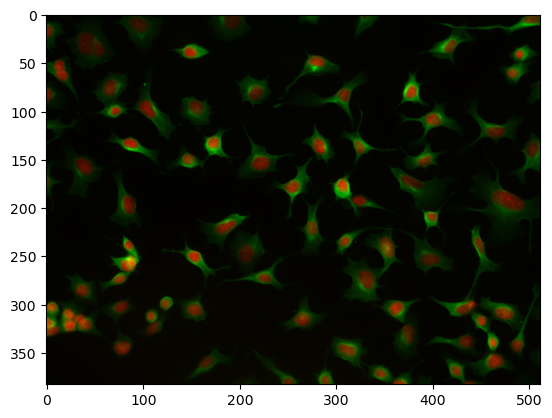

In [ ]:
img_vec_out = es.result.reshape(imgb.shape)
plt.imshow(img_vec_out)
imgb.shape